In [1]:
from collections import Counter
from PIL import Image as im
import numpy as np
from matplotlib import pyplot as plt
import os
import keras as k
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical                 
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, RandomRotation, RandomFlip, RandomZoom, RandomContrast
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import ImageFile
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import seaborn as sns
import tensorflow_addons as tfa

tf.config.set_soft_device_placement(True) 
ImageFile.LOAD_TRUNCATED_IMAGES = True
img_res = [224, 224]

/Users/wbowers/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load dataset
def load_data(pathname):
    images = []
    labels = []
    dataset = pathname
    categories = os.listdir(os.getcwd() + "/" + dataset)
    weird_count = 0
    count = 0

    for i in tqdm(range(len(categories))):
        for filename in tqdm(os.listdir(os.getcwd() + '/' + dataset + '/' + categories[i] + '/'), leave=False):
            image = im.open(os.getcwd() + '/' + dataset + '/' + categories[i] + '/' + filename)
            np_img = np.array(image.resize((img_res[1], img_res[0])))
            if np_img.shape == (img_res[0], img_res[1], 3):
                images.append(np_img)
                labels.append(i)
                count += 1

    # split into train and test sets 
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=1)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    # reshape data into 2d arrays so it can be processed
    nsamples, nx, ny, d3 = X_train.shape
    X_train = X_train.reshape((nsamples,d3*nx*ny))

    # Randomly oversample minority classes
    X_train_ros, y_train_ros= SMOTE().fit_resample(X_train, y_train)

    # Check distribution of data across classes
    print(sorted(Counter(y_train_ros).items()))

    # resize data back into original shape
    nsamples = X_train_ros.shape[0]
    X_train_ros = X_train_ros.reshape((nsamples, nx, ny, d3))

    X_train = X_train_ros
    y_train = y_train_ros

    # some preprocessing on the data

    # normalizing the data to be from 0-1 instead 1-255
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255

    # format the target data to match the output data of the cnn
    # so you can compare the two
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return [X_train, y_train, X_test, y_test, categories]

In [4]:
[X_train_v1, y_train_v1, X_test_v1, y_test_v1, categories_v1] = load_data("dataset-v1")
[X_train_v2, y_train_v2, X_test_v2, y_test_v2, categories_v2] = load_data("dataset-v2")

100%|██████████| 12/12 [01:33<00:00,  7.75s/it]


[(0, 1936), (1, 1936), (2, 1936), (3, 1936), (4, 1936), (5, 1936), (6, 1936), (7, 1936), (8, 1936), (9, 1936), (10, 1936), (11, 1936)]


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


[(0, 486), (1, 486), (2, 486), (3, 486), (4, 486), (5, 486)]


In [5]:
[X_train_v3, y_train_v3, X_test_v3, y_test_v3, categories_v3] = load_data("dataset-v3")

100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


[(0, 1551), (1, 1551), (2, 1551), (3, 1551), (4, 1551), (5, 1551), (6, 1551), (7, 1551), (8, 1551), (9, 1551), (10, 1551), (11, 1551), (12, 1551), (13, 1551), (14, 1551), (15, 1551), (16, 1551), (17, 1551), (18, 1551), (19, 1551)]


First, let's create and evaluate a model for dataset 1:

In [6]:
# data augmentation
with tf.device('/cpu:0'):
    data_augmentation = k.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, input_shape=(img_res[0], img_res[1], 3)),
    RandomZoom(0.2, 0.2),
    ])

base_model = k.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_res[0], img_res[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = k.Input(shape=(img_res[0], img_res[1], 3))
x = data_augmentation(inputs)
x = base_model(x)
x = k.layers.GlobalAveragePooling2D() (x)
x = k.layers.Dense(128) (x)
x = k.layers.Dropout(0.2) (x)
x = k.layers.Dense(64) (x)
x = k.layers.Dropout(0.2) (x)
x = k.layers.BatchNormalization() (x)
outputs = k.layers.Dense(len(categories_v1), activation = 'softmax') (x)

model_v1 = k.Model(inputs, outputs)

learning_rate = 0.0015

model_v1.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                loss=k.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

2023-03-13 14:20:35.479507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 14:20:35.480041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



Epoch 1/4


2023-03-13 11:45:43.074359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


654/654 [==============================] - ETA: 0s - loss: 2.5341 - accuracy: 0.0935

2023-03-13 11:47:54.613671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Saving model...
654/654 [==============================] - 143s 210ms/step - loss: 2.5341 - accuracy: 0.0935 - val_loss: 3.7435 - val_accuracy: 0.0000e+00
Epoch 2/4
654/654 [==============================] - 135s 206ms/step - loss: 2.4714 - accuracy: 0.0896 - val_loss: 3.8990 - val_accuracy: 0.0000e+00
Epoch 3/4
654/654 [==============================] - 135s 207ms/step - loss: 2.4637 - accuracy: 0.0893 - val_loss: 3.7641 - val_accuracy: 0.0000e+00
Epoch 4/4
119/119 [==============================] - 11s 95ms/step - loss: 2.4687 - accuracy: 0.0803
loss / crossentropy / accuracy:
2.4686954021453857
0.08028429001569748


2023-03-13 11:55:06.014156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 13s 92ms/step
                    precision    recall  f1-score   support

           paper 2     0.0000    0.0000    0.0000       120
           clothes     0.0000    0.0000    0.0000       238
trashbox-cardboard     0.0000    0.0000    0.0000       382
   orig-metal-cans     0.0000    0.0000    0.0000       232
  Paper Bag Images     0.0000    0.0000    0.0000       446
Plastic Bag Images     0.0000    0.0000    0.0000       397
        biological     0.0000    0.0000    0.0000       367
   plastic-bottles     0.0000    0.0000    0.0000       463
           battery     0.0000    0.0000    0.0000       354
             shoes     0.0000    0.0000    0.0000       419
     glass-v1-orig     0.0000    0.0000    0.0000       267
           diapers     0.0000    0.0000    0.0000       114

         micro avg     0.0000    0.0000    0.0000      3799
         macro avg     0.0000    0.0000    0.0000      3799
      weighted avg     0.0000    0.0000  

/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


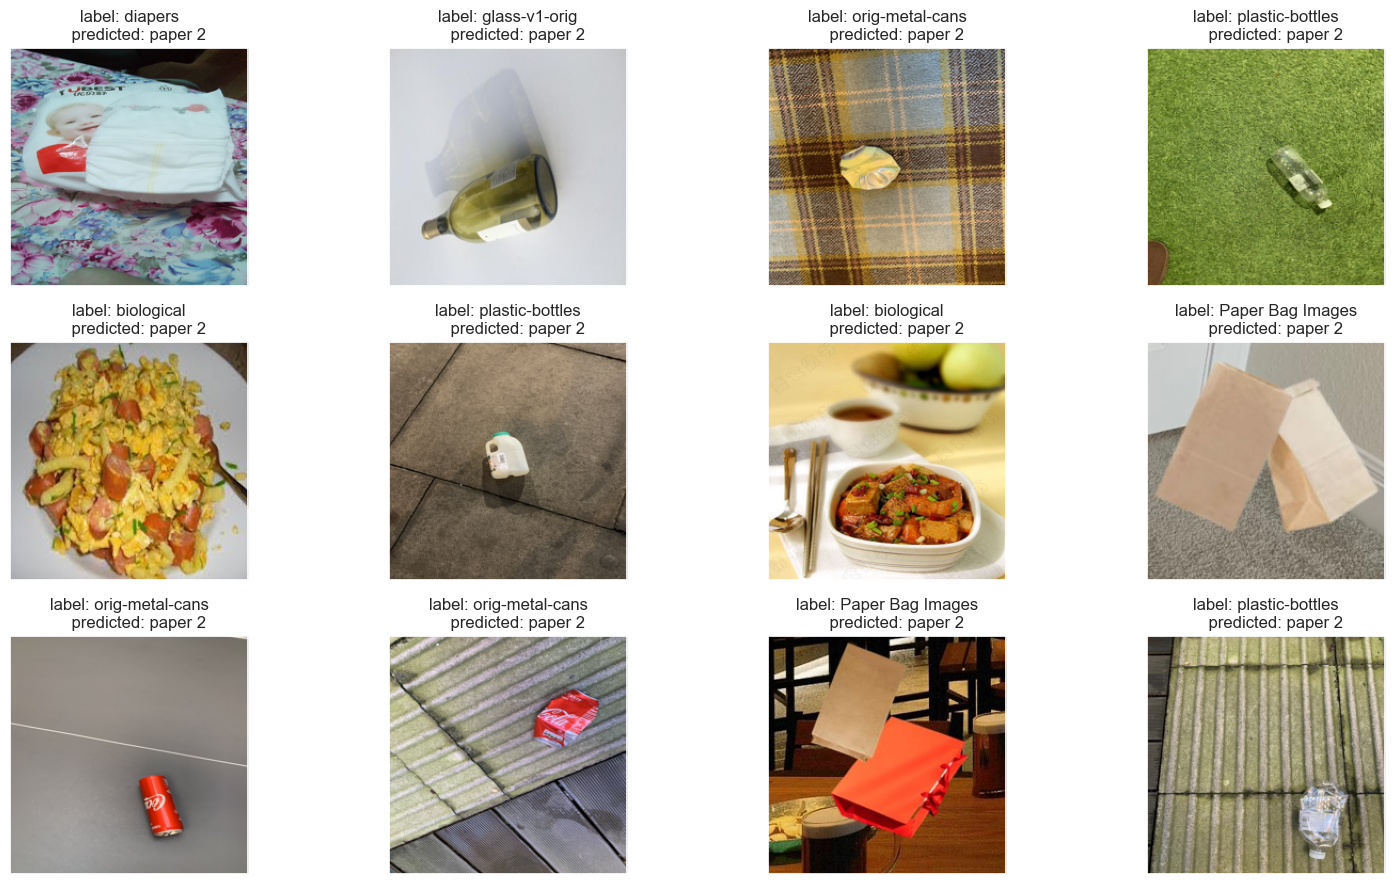

In [40]:
epoch_counter = 2

# save the data to a file that can later be converted to the CoreML format
class SaveModelCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global epoch_counter
        print("Saving model...")
        self.model.save("model_epoch_" + str(epoch_counter) + ".h5")
        epoch_counter += 1
        
# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/gpu:0"):       
    history = model_v1.fit(X_train_v1, y_train_v1, epochs=4, batch_size=32, validation_split=0.1, shuffle = True, callbacks=[SaveModelCallback()])


# evalutating the loss/accuracy of the model on the test set
loss, accuracy = model_v1.evaluate(X_test_v1, y_test_v1)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred = model_v1.predict(X_test_v1)

y_pred = (y_pred > 0.5) 

print(classification_report(y_test_v1, y_pred, target_names=categories_v1, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v1)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v1[index], y_test_v1[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v1[np.argmax(target)] + '''
    predicted: ''' + categories_v1[np.argmax(predict)])
plt.tight_layout()
plt.show()             

Wow. The model is pretty awful.
Now, let's create a model for dataset2 and evaluate it:

In [53]:
outputs = k.layers.Dense(len(categories_v2), activation = 'softmax') (x) # adjust number of categories 
model_v2 = k.Model(inputs, outputs)
learning_rate = 0.0015
model_v2.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                loss=k.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

Epoch 1/4


2023-03-13 12:01:18.944606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - ETA: 0s - loss: 1.0345 - accuracy: 0.6258

2023-03-13 12:01:37.993695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Saving model...
328/328 [==============================] - 24s 62ms/step - loss: 1.0345 - accuracy: 0.6258 - val_loss: 2.7651 - val_accuracy: 0.3425
Epoch 2/4
328/328 [==============================] - 17s 52ms/step - loss: 0.7775 - accuracy: 0.7130 - val_loss: 2.7591 - val_accuracy: 0.3425
Epoch 3/4
328/328 [==============================] - 17s 52ms/step - loss: 0.6981 - accuracy: 0.7580 - val_loss: 3.4303 - val_accuracy: 0.3014
Epoch 4/4
16/16 [==============================] - 2s 98ms/step - loss: 0.4619 - accuracy: 0.8538
loss / crossentropy / accuracy:
0.4619317650794983
0.853754997253418


2023-03-13 12:02:34.246063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 3s 98ms/step
              precision    recall  f1-score   support

       paper     0.9167    0.8148    0.8627       108
       metal     0.9028    0.7927    0.8442        82
   cardboard     0.9589    0.8642    0.9091        81
       trash     0.6667    0.5517    0.6038        29
       glass     0.8409    0.7475    0.7914        99
     plastic     0.8350    0.8037    0.8190       107

   micro avg     0.8750    0.7885    0.8295       506
   macro avg     0.8535    0.7624    0.8050       506
weighted avg     0.8747    0.7885    0.8291       506
 samples avg     0.7885    0.7885    0.7885       506

[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0.]


/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


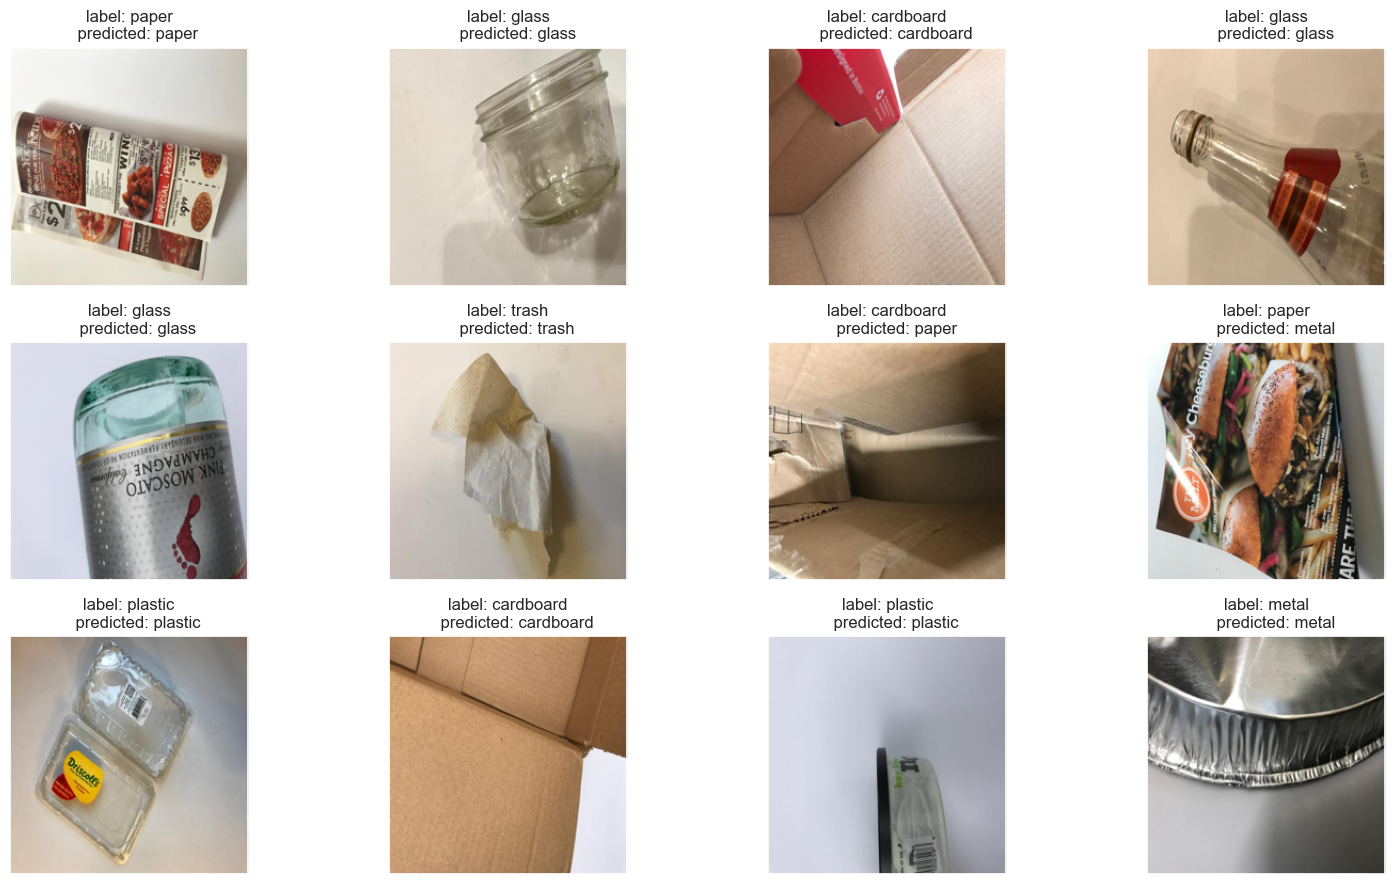

In [54]:
epoch_counter = 2

# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/gpu:0"):       
    history = model_v2.fit(X_train_v2, y_train_v2, epochs=4, batch_size=8, validation_split=0.1, shuffle = True, callbacks=[SaveModelCallback()])


# evalutating the loss/accuracy of the model on the test set
loss, accuracy = model_v2.evaluate(X_test_v2, y_test_v2)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred = model_v2.predict(X_test_v2)

y_pred = (y_pred > 0.5) 

print(classification_report(y_test_v2, y_pred, target_names=categories_v2, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v2)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v2[index], y_test_v2[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v2[np.argmax(target)] + '''
    predicted: ''' + categories_v2[np.argmax(predict)])
plt.tight_layout()
plt.show()   

The model seems WAY better with this dataset. A bit confused by this...

Let's play around with keras fine tuning using datasetv2

In [56]:
import keras_tuner as kt

# data augmentation
with tf.device('/cpu:0'):
    data_augmentation_light = k.Sequential([
    RandomRotation(0.1, input_shape=(img_res[0], img_res[1], 3)),
    ])

    data_augmentation_heavy = k.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2, input_shape=(img_res[0], img_res[1], 3)),
    RandomZoom(0.2, 0.2),
    #RandomContrast(0.2),
    ])

base_model = k.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_res[0], img_res[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False


def build_model(hp):
    inputs = k.Input(shape=(img_res[0], img_res[1], 3))
    if hp.Boolean("data_aug_heavy"):
        x = data_augmentation_heavy(inputs)
    else:
        x = data_augmentation_light(inputs)
    x = base_model(x)
    x = k.layers.GlobalAveragePooling2D() (x)
    x = k.layers.Dense(units=hp.Int("dense1", min_value=32, max_value=1024, step=32),) (x)
    if hp.Boolean("dropout1"):
        x = k.layers.Dropout(0.2) (x)
    x = k.layers.Dense(units=hp.Int("dense2", min_value=32, max_value=512, step=32),) (x)
    if hp.Boolean("dropout2"):
        x = k.layers.Dropout(0.2) (x)
    if hp.Boolean("batchnorm"):
        x = k.layers.BatchNormalization() (x)
    outputs = k.layers.Dense(len(categories_v2), activation = 'softmax') (x)

    model = k.Model(inputs, outputs)

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                  loss=k.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=6,
    executions_per_trial=3,
    overwrite=True,
    directory="keras_tuner-model",
    project_name="waste_classification_model",
)

tuner.search_space_summary()


Search space summary
Default search space size: 7
data_aug_heavy (Boolean)
{'default': False, 'conditions': []}
dense1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout1 (Boolean)
{'default': False, 'conditions': []}
dense2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout2 (Boolean)
{'default': False, 'conditions': []}
batchnorm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [57]:
tuner.search(X_train_v2, y_train_v2, epochs=3, validation_split = 0.1, batch_size = 8)

Trial 6 Complete [00h 03m 04s]
val_accuracy: 0.3835616409778595

Best val_accuracy So Far: 0.43150684237480164
Total elapsed time: 00h 17m 44s
INFO:tensorflow:Oracle triggered exit


In [83]:
best_hps = tuner.get_best_hyperparameters(5)
model_tuned = build_model(best_hps[0])
print(model_tuned.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 32)                40992     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0   

Epoch 1/4


2023-03-13 13:16:57.744123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - ETA: 0s - loss: 1.1534 - accuracy: 0.5770

2023-03-13 13:17:26.049250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Saving model...
328/328 [==============================] - 35s 90ms/step - loss: 1.1534 - accuracy: 0.5770 - val_loss: 2.9698 - val_accuracy: 0.3527
Epoch 2/4
328/328 [==============================] - 21s 65ms/step - loss: 0.8371 - accuracy: 0.6886 - val_loss: 2.8277 - val_accuracy: 0.4007
Epoch 3/4
328/328 [==============================] - 21s 64ms/step - loss: 0.7189 - accuracy: 0.7416 - val_loss: 2.7954 - val_accuracy: 0.3459
Epoch 4/4
16/16 [==============================] - 5s 231ms/step - loss: 0.5833 - accuracy: 0.8063
loss / crossentropy / accuracy:
0.5833308100700378
0.8063241243362427


2023-03-13 13:18:40.308594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 5s 198ms/step
              precision    recall  f1-score   support

       paper     0.9861    0.6574    0.7889       108
       metal     0.7103    0.9268    0.8042        82
   cardboard     0.8667    0.9630    0.9123        81
       trash     0.8421    0.5517    0.6667        29
       glass     0.8481    0.6768    0.7528        99
     plastic     0.8875    0.6636    0.7594       107

   micro avg     0.8479    0.7490    0.7954       506
   macro avg     0.8568    0.7399    0.7807       506
weighted avg     0.8662    0.7490    0.7908       506
 samples avg     0.7490    0.7490    0.7490       506



/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0.]


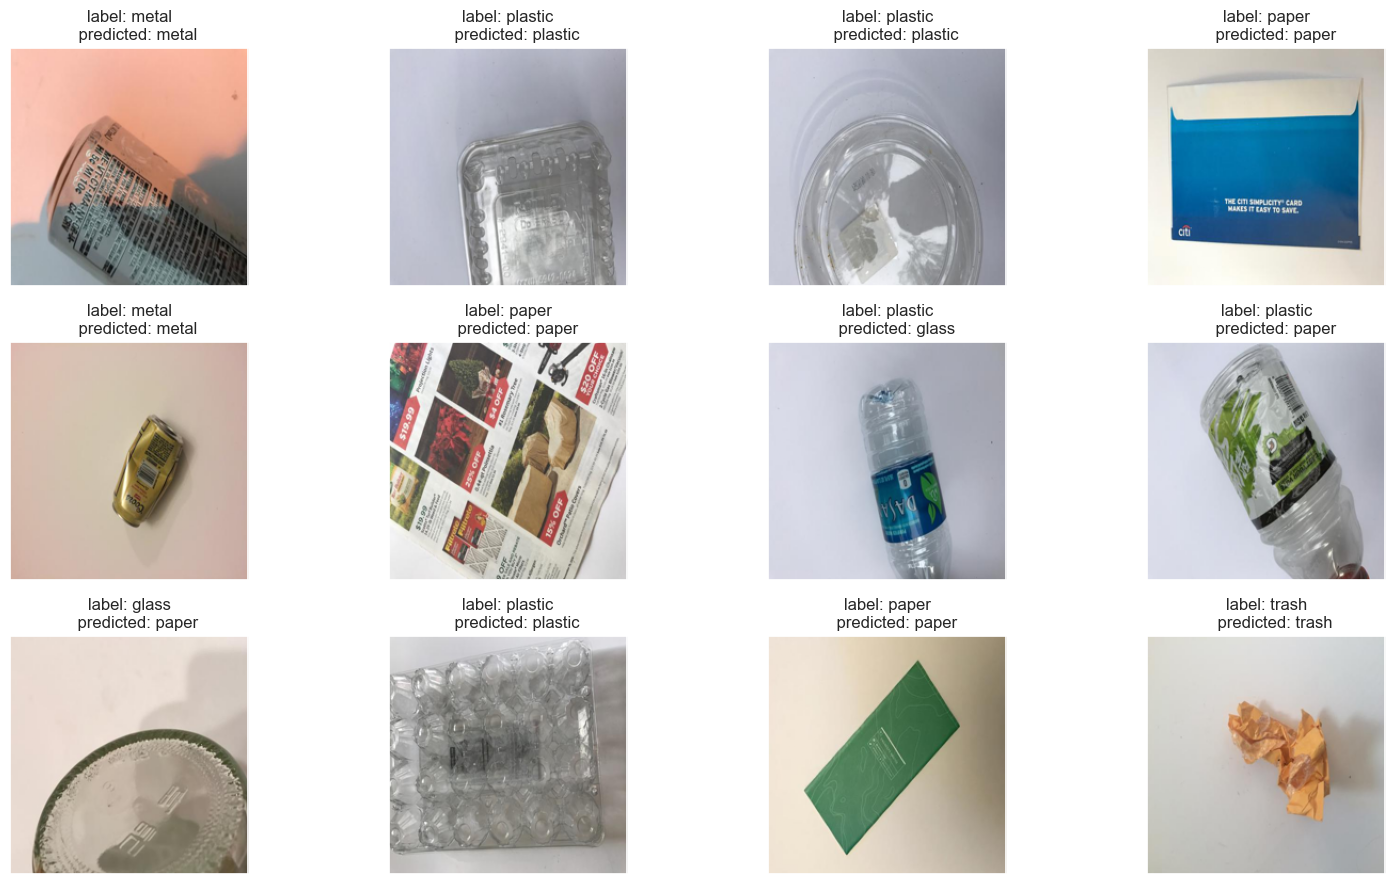

In [84]:
epoch_counter = 2

# actually running the cnn and fitting/training neural network on the data
# batch size = after 64 samples, make a small adjustment
# epoch = every time all the data is run through, make a big adjustment
with tf.device("/gpu:0"):       
    history = model_tuned.fit(X_train_v2, y_train_v2, epochs=4, batch_size=8, validation_split=0.1, shuffle = True, callbacks=[SaveModelCallback()])


# evalutating the loss/accuracy of the model on the test set
loss, accuracy = model_tuned.evaluate(X_test_v2, y_test_v2)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred = model_tuned.predict(X_test_v2)

y_pred = (y_pred > 0.5) 

print(classification_report(y_test_v2, y_pred, target_names=categories_v2, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v2)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v2[index], y_test_v2[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v2[np.argmax(target)] + '''
    predicted: ''' + categories_v2[np.argmax(predict)])
plt.tight_layout()
plt.show()   

To-do:
- Make a better dataset (more categories maybe)

Seems like fine tuning barely made a difference. Let's stick with the normal model for now since tuning takes forever.

Now, let's try our model out on dataset v3

In [7]:
outputs = k.layers.Dense(len(categories_v3), activation = 'softmax') (x)
model_v3 = k.Model(inputs, outputs)
learning_rate = 0.0015
model_v3.compile(optimizer=k.optimizers.Adam(learning_rate = learning_rate),
                loss=k.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

Epoch 1/4


2023-03-13 14:21:02.808460: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-13 14:21:04.385060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


437/437 [==============================] - ETA: 0s - loss: 1.3167 - accuracy: 0.6008

2023-03-13 14:23:56.269716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


437/437 [==============================] - 191s 431ms/step - loss: 1.3167 - accuracy: 0.6008 - val_loss: 3.3602 - val_accuracy: 0.1760
Epoch 2/4
437/437 [==============================] - 187s 429ms/step - loss: 1.0410 - accuracy: 0.6808 - val_loss: 2.9043 - val_accuracy: 0.2608
Epoch 3/4
437/437 [==============================] - 186s 426ms/step - loss: 0.9649 - accuracy: 0.6974 - val_loss: 3.8472 - val_accuracy: 0.1738
Epoch 4/4
437/437 [==============================] - 188s 431ms/step - loss: 0.9328 - accuracy: 0.7139 - val_loss: 3.3138 - val_accuracy: 0.2437


2023-03-13 14:33:36.271535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 5s 58ms/step - loss: 0.7689 - accuracy: 0.7721
loss / crossentropy / accuracy:
0.7689063549041748
0.7721265554428101


2023-03-13 14:33:43.143477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 5s 53ms/step
                    precision    recall  f1-score   support

             paper     0.8438    0.6193    0.7143       218
         medicines     0.9623    0.6892    0.8031        74
    cigarette butt     0.9429    0.9296    0.9362        71
         tetra pak     0.9615    0.7353    0.8333       136
  metal containers     0.5124    0.7750    0.6169        80
 electrical cables     0.8553    0.6633    0.7471        98
   plastic bottles     0.7679    0.5181    0.6187        83
      plastic cups     0.7222    0.5065    0.5954        77
         cardboard     0.8531    0.7844    0.8173       385
      plastic bags     0.7692    0.7042    0.7353        71
           laptops     0.8246    0.6184    0.7068        76
  small appliances     0.9633    0.7895    0.8678       133
             glass     0.8602    0.7951    0.8264       410
            gloves     0.8519    0.7188    0.7797        64
       smartphones     0.8158    0.7750    0.

/Users/wbowers/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


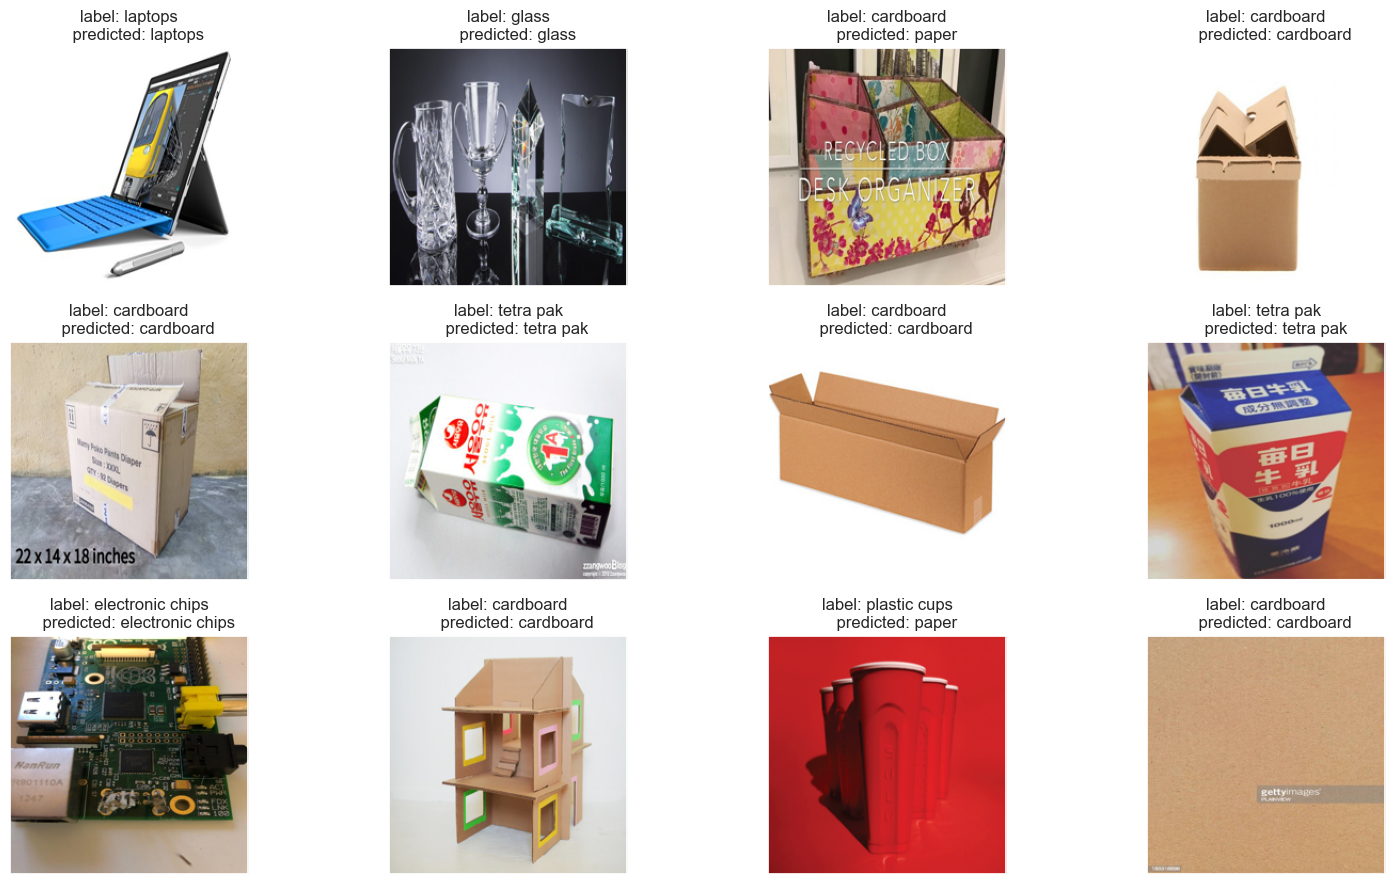

In [9]:
with tf.device("/cpu:0"):       
    history = model_v3.fit(X_train_v3, y_train_v3, epochs=4, batch_size=64, validation_split=0.1, shuffle = True)
loss, accuracy = model_v3.evaluate(X_test_v3, y_test_v3)
print("loss / crossentropy / accuracy:")
print(loss)
print(accuracy)

"""
IF MODEL DOESNT KNOW, RETURN GARBAGE AND SAY WE'RE NOT QUITE SURE
Resource: https://www.ridwell.com/
"""

acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

y_pred = model_v3.predict(X_test_v3)

y_pred = (y_pred > 0.5) 

print(classification_report(y_test_v3, y_pred, target_names=categories_v3, digits=4))



# visualize 24 random results
sns.set(font_scale=1)
index = np.random.choice(np.arange(len(X_test_v3)), 12, replace=False)    # pick 24 random smamples
figure, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,9))           # set dimensions
for item in zip(axes.ravel(), X_test_v3[index], y_test_v3[index], y_pred[index]):          # put each sample into a "slot" in the table
    axes, image, target, predict = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    print(target)
    axes.set_title("label: " + categories_v3[np.argmax(target)] + '''
    predicted: ''' + categories_v3[np.argmax(predict)])
plt.tight_layout()
plt.show()  